# one working ith train_cluster_cinn_combined

In [6]:
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

def produce_emb_scalar_from_file(embedding_path, scaler_path="/u/jshera/MAPS_CINN/simclr_results/processed_data/emb_scaler.pkl"):
    """
    Loads embeddings from a file, fits a StandardScaler, and saves it.
    
    Args:
        embedding_path (str): Path to the .npy file containing embeddings.
        scaler_path (str): File path where the scaler will be saved.
    """
    # Load embeddings
    embeddings = np.load(embedding_path)
    
    # Fit scaler
    emb_scaler = StandardScaler().fit(embeddings)
    
    # Save scaler
    joblib.dump(emb_scaler, scaler_path)
    
    print(f"Scaler saved to {scaler_path}")
    return emb_scaler

# Usage example:
embedding_file = "/u/jshera/MAPS_CINN/simclr_results/embeddings.npy"
emb_scaler = produce_emb_scalar_from_file(embedding_file)


Scaler saved to /u/jshera/MAPS_CINN/simclr_results/processed_data/emb_scaler.pkl


In [5]:
def plot_figure14_combined(
        model_checkpoint: str,
        processed_dir: str = "processed_data",
        embeddings_npy: str = "embeddings.npy",
        filenames_npy: str  = "filenames.npy",
        n_rows: int       = 200,
        n_samples: int    = 600,
        random_state: int = 42,
        select_halo_ids: list = None,
        select_snapshots: list = None):
    """
    Same as plot_figure14, but conditions on BOTH observables (X.csv) 
    and representation‐space embeddings.
    """
    import os, re
    import numpy as np
    import pandas as pd
    import torch
    import joblib
    import matplotlib.pyplot as plt
    from sklearn.neighbors import KernelDensity
    from sklearn.model_selection import train_test_split
    from cluster_cinn import cINN

    # 1) Load scaled observables + targets + meta + scalers
    dfX     = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY     = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    df_meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_full  = dfX.values           # (N, D_obs)
    Y_full  = dfY.values           # (N, D_tar)
    obs_sc  = joblib.load(os.path.join(processed_dir, "obs_scaler.pkl"))
    tar_sc  = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape

    # 2) Recover the SAME test‐set split
    idx, idx_tmp = np.arange(N), None
    idx_tmp, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    val_frac         = 0.1 / 0.9
    idx_train, idx_val = train_test_split(idx_tmp, test_size=val_frac, random_state=random_state)

    X_test    = X_full[idx_test]
    Y_test    = Y_full[idx_test]
    meta_test = df_meta.iloc[idx_test].reset_index(drop=True)
    halo_ids     = meta_test["HaloID"].values
    snapshot_ids = meta_test["Snapshot"].values

    # 3) Build “prior” KDEs on each target in physical units
    Yp = tar_sc.inverse_transform(Y_test)
    priors = []
    for d in range(D_tar):
        data = Yp[:, d][:, None]
        kde  = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data)
        grid = np.linspace(data.min(), data.max(), 200)[:, None]
        dens = np.exp(kde.score_samples(grid))
        dens /= dens.max()
        priors.append((grid.ravel(), dens))

    # 4) Load & scale embeddings **for the test set**
    def normalize_fname(fname: str) -> str:
        base = os.path.splitext(os.path.basename(fname))[0]
        m = re.match(r"^snap_(\d+)_halo_(\d+)_proj_\d+$", base)
        snap, halo = int(m.group(1)), int(m.group(2))
        return f"{halo}_{snap}"

    # 4a) Build key→embedding map
    all_emb    = np.load(embeddings_npy)    # (N_proj, D_emb)
    all_fnames = np.load(filenames_npy)     # (N_proj,)
    df_emb     = pd.DataFrame(all_emb)
    df_emb["key"] = [normalize_fname(f) for f in all_fnames]
    emb_map = {
        row["key"]: row.drop("key").values
        for _, row in df_emb.iterrows()
    }

    # 4b) Fetch embeddings in test‐set order
    missing, E_list = [], []
    for _, row in meta_test.iterrows():
        key = f"{int(row.HaloID)}_{int(row.Snapshot)}"
        emb = emb_map.get(key)
        if emb is None:
            missing.append(key)
        else:
            E_list.append(emb)
    if missing:
        raise KeyError("Missing embeddings for keys: " + ", ".join(missing))
    E_test_raw = np.vstack(E_list)        # (len(idx_test), D_emb)

    # 4c) Scale embeddings
    emb_sc = joblib.load(os.path.join(processed_dir, "emb_scaler.pkl"))
    E_test = emb_sc.transform(E_test_raw) # (len(idx_test), D_emb)

    # 5) Combine observables + embeddings into one condition matrix
    X_test_cond = np.hstack([X_test, E_test])  # (len(idx_test), D_obs + D_emb)
    D_obs_comb  = X_test_cond.shape[1]

    # 6) Load your trained cINN with the combined input‐dim
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(y_dim=D_tar, x_dim=D_obs_comb, hidden_dim=128, n_blocks=12, clamp=2.0)
    model  = model.to(device).eval()
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)

    # 7) Select which test rows to plot
    if select_halo_ids is not None and select_snapshots is not None:
        if len(select_halo_ids) != len(select_snapshots):
            raise ValueError("select_halo_ids and select_snapshots length mismatch")
        chosen = []
        for hid, snap in zip(select_halo_ids, select_snapshots):
            idxs = meta_test[
                (meta_test["HaloID"] == hid) &
                (meta_test["Snapshot"] == snap)
            ].index.tolist()
            if not idxs:
                raise ValueError(f"No test entry for HaloID={hid}, Snapshot={snap}")
            chosen.append(idxs[0])
        n_rows = len(chosen)
    else:
        rng    = np.random.RandomState(random_state)
        chosen = rng.choice(len(X_test_cond), size=n_rows, replace=False).tolist()

    # 8) Sample posteriors, compute MAPs & truths
    post_phys = np.zeros((n_rows, n_samples, D_tar))
    maps_phys = np.zeros((n_rows, D_tar))
    true_phys = np.zeros((n_rows, D_tar))

    for i_row, idx0 in enumerate(chosen):
        x0 = torch.tensor(
            X_test_cond[idx0:idx0+1],
            dtype=torch.float32,
            device=device
        )
        Z  = torch.randn(n_samples, D_tar, device=device)
        with torch.no_grad():
            inv_out = model.inverse(Z, x0.repeat(n_samples, 1))
            Ys = inv_out[0] if isinstance(inv_out, tuple) else inv_out
        Ys = Ys.cpu().numpy()
        post_phys[i_row] = tar_sc.inverse_transform(Ys)

        # MAP via KDE
        for d in range(D_tar):
            samp = post_phys[i_row, :, d][:, None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samp)
            g2   = np.linspace(samp.min(), samp.max(), 200)[:, None]
            ld2  = kde2.score_samples(g2)
            maps_phys[i_row, d] = g2[np.argmax(np.exp(ld2)), 0]

        true_phys[i_row] = tar_sc.inverse_transform(Y_test[idx0:idx0+1])[0]

    # 9) Plot exactly as before
    target_labels = [
    'last_T_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    ]

    fig, axes = plt.subplots(
        n_rows, D_tar,
        figsize=(3 * D_tar, 1.25 * n_rows),
        sharex="col", squeeze=False
    )

    for i_row, gal in enumerate(chosen):
        axes[i_row, 0].text(
            -0.12, 0.5,
            f"{snapshot_ids[gal]}\n{halo_ids[gal]}",
            transform=axes[i_row, 0].transAxes,
            va="center", ha="right", fontsize=8
        )
        for d in range(D_tar):
            ax = axes[i_row, d]
            # PRIOR
            g_prior, pd_prior = priors[d]
            ax.fill_between(g_prior, pd_prior, color="lightgrey", alpha=0.6)
            ax.plot(g_prior, pd_prior, "k--", lw=1)
            # POSTERIOR
            samp = post_phys[i_row, :, d][:, None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(samp)
            g_post = np.linspace(samp.min(), samp.max(), 200)[:, None]
            pd_post = np.exp(kde2.score_samples(g_post))
            pd_post /= pd_post.max()
            ax.plot(g_post.ravel(), pd_post, color="C0", lw=2)
            # MAP & truth
            ax.axvline(maps_phys[i_row, d], color="gold", lw=1.5)
            ax.axvline(true_phys[i_row, d], color="red",  lw=1.5)
            ax.set_xlim(g_prior.min(), g_prior.max())
            if i_row == n_rows - 1:
                ticks = np.linspace(g_prior.min(), g_prior.max(), 5)
                ax.set_xticks(ticks)
                ax.set_xticklabels([f"{t:.2f}" for t in ticks],
                                   fontsize=6, rotation=45)
            else:
                ax.set_xticks([])
            if i_row == 0:
                ax.set_title(target_labels[d], fontsize=10)
            ax.set_yticks([])

    plt.tight_layout()
    #fig.savefig("figure14_combined.pdf", bbox_inches="tight")
    #fig.savefig("figure14_combined.png", bbox_inches="tight")
    plt.show()


In [7]:
# plot by specifying exact galaxies:
halo_ids    = [3655354, 18755555, 18640157, 10913474, 6775821, 3960854, 7117080
                ,19406945, 14397702, 1610308, 13826982, 16276166, 6921818, 18700555, 17022321]
snapshots   = [50, 67, 59, 84, 72, 99, 72
                , 78, 99, 99, 84, 99, 91, 91, 84]
plot_figure14_combined(
    model_checkpoint="best_cluster_cinn_combined.pt",
    processed_dir="processed_data",
    embeddings_npy="embeddings.npy",
    filenames_npy="filenames.npy",
    select_halo_ids=halo_ids,
    select_snapshots=snapshots,
    n_samples=200
)

ValueError: No test entry for HaloID=3655354, Snapshot=50

# one working with trian_cluster_cinn_prohjections.py

In [1]:
# ── cluster_cinn.py ──
import torch
import torch.nn as nn
from FrEIA.framework import (
    InputNode, ConditionNode, Node, OutputNode, ReversibleGraphNet
)
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom

class cINN(nn.Module):
    """
    A conditional INN with GLOW‐style affine couplings,
    now conditioned *only* on the image embedding (no scalars).
    """
    def __init__(self,
                 y_dim:int,
                 x_dim:int,
                 hidden_dim:int=128,
                 n_blocks:int=12,
                 clamp:float=2.0):
        super().__init__()
        # 1) Conditioning node
        cond_node = ConditionNode(x_dim, name='cond')
        # 2) Main y‐input node
        nodes = [InputNode(y_dim, name='y_in')]

        # 3) Subnet: small MLP w/ dropout
        def subnet_constructor(ch_in, ch_out):
            return nn.Sequential(
                nn.Linear(ch_in, hidden_dim),
                nn.ReLU(),
                nn.Dropout(p=0.1),
                nn.Linear(hidden_dim, ch_out)
            )

        # 4) Stack GLOW couplings + random permutations
        for i in range(n_blocks):
            nodes.append(
                Node(
                    nodes[-1],
                    GLOWCouplingBlock,
                    {
                      'subnet_constructor': subnet_constructor,
                      'clamp': clamp
                    },
                    conditions=cond_node,
                    name=f'coupling_{i}'
                )
            )
            nodes.append(
                Node(
                    nodes[-1],
                    PermuteRandom,
                    {'seed': i},
                    name=f'permute_{i}'
                )
            )

        # 5) Output node
        nodes.append(OutputNode(nodes[-1], name='y_out'))
        # 6) Build reversible graph
        self.flow = ReversibleGraphNet(nodes + [cond_node], verbose=False)

    def forward(self, y: torch.Tensor, x: torch.Tensor):
        return self.flow(y, c=x)

    def inverse(self, z: torch.Tensor, x: torch.Tensor):
        return self.flow(z, c=x, rev=True)


In [26]:
import os
import re
import yaml
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.neighbors    import KernelDensity

from models.joint_model import JointModel
from data.data_augmentor import DataAugmentor

def plot_figure14_combined(
    joint_checkpoint: str,
    processed_dir:     str = "processed_data",
    filenames_npy:     str = "filenames.npy",
    n_rows:            int = 8,
    n_samples:         int = 600,
    random_state:      int = 42,
    select_rows:       list = None,
    select_halo_ids:   list = None,
    select_snapshots:  list = None,
):
    # ─── Load configs ─────────────────────────────────────
    ds_cfg = yaml.safe_load(open("configs/dataset_config.yaml"))["dataset"]
    data_dir = ds_cfg["data_path"]

    # ─── Load JointModel ──────────────────────────────────
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    joint  = JointModel.load_from_checkpoint(joint_checkpoint)\
                       .eval().to(device)

    # ─── Load scalers + metadata ──────────────────────────
    tar_sc  = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    dfY     = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    df_meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    df_meta["cluster_idx"] = df_meta.index
    Y_clust = dfY.values

    # replicate for proj=1,2,3
    projs = [1,2,3]
    df_meta_rep = pd.concat([df_meta.assign(proj=p) for p in projs],
                             ignore_index=True)
    df_meta_rep["key"] = (
        df_meta_rep["HaloID"].astype(int).astype(str) + "_" +
        df_meta_rep["Snapshot"].astype(int).astype(str) + "_" +
        df_meta_rep["proj"].astype(int).astype(str)
    )
    Y_rep = np.repeat(Y_clust, len(projs), axis=0)

    # ─── Train/test split on projections ──────────────────
    N = len(df_meta_rep)
    _, idx_test = train_test_split(np.arange(N),
                                   test_size=0.1,
                                   random_state=random_state)
    df_test = df_meta_rep.iloc[idx_test].reset_index(drop=True)
    Y_test  = Y_rep[idx_test]
    print(f"Total proj: {N}, test‐set: {len(idx_test)}")

    # ─── Build priors ─────────────────────────────────────
    Y_phys = tar_sc.inverse_transform(Y_test)
    D_tar  = Y_phys.shape[1]
    priors = []
    for d in range(D_tar):
        data = Y_phys[:,d][:,None]
        kde  = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data)
        grid = np.linspace(data.min(), data.max(), 200)[:,None]
        dens = np.exp(kde.score_samples(grid))
        dens /= dens.max()
        priors.append((grid.ravel(), dens))

    # ─── Pick rows to plot ────────────────────────────────
    if select_halo_ids and select_snapshots:
        chosen = []
        for hid, snap in zip(select_halo_ids, select_snapshots):
            hits = df_test[(df_test["HaloID"]==hid)
                        & (df_test["Snapshot"]==snap)].index.tolist()
            if hits:
                chosen.append(hits[0])
        if not chosen:
            raise ValueError("No matching halo/snapshot in test set")
    elif select_rows:
        chosen = select_rows
    else:
        M = len(df_test)
        rng = np.random.RandomState(random_state)
        chosen = rng.choice(M, size=min(n_rows,M),
                            replace=False).tolist()

    n_plot = len(chosen)

    # ─── Prepare test transform ───────────────────────────
    augmentor      = DataAugmentor(
        augmentations_config="configs/augmentations_config.yaml",
        dataset_config="configs/dataset_config.yaml",
        main_config="configs/main_config.yaml"
    )
    test_tf_single = augmentor.get_test_transform()

    # ─── Build filename map (key→full path) ──────────────
    F_all = np.load(filenames_npy)
    prog  = re.compile(r"^snap_(\d+)_halo_(\d+)_proj_(\d+)")
    fname_map = {}
    for fn in F_all:
        b = os.path.basename(fn)
        m = prog.match(b)
        if not m: continue
        snap, halo, proj = map(int, m.groups())
        key = f"{halo}_{snap}_{proj}"
        # if fn is relative, join with data_dir
        full = fn if os.path.isabs(fn) else os.path.join(data_dir, b)
        fname_map[key] = full

    # ─── Sample posterior & compute MAP/truth ─────────────
    post_phys = np.zeros((n_plot, n_samples, D_tar))
    maps_phys = np.zeros((n_plot, D_tar))
    true_phys = np.zeros((n_plot, D_tar))

    for i, sel in enumerate(chosen):
        row = df_test.iloc[sel]
        key = row["key"]
        img_path = fname_map.get(key)
        if img_path is None or not os.path.isfile(img_path):
            raise FileNotFoundError(f"Missing image for {key}: {img_path}")
        img = Image.open(img_path).convert("RGB")

        x   = test_tf_single(img).unsqueeze(0).to(device)
        h0  = joint.backbone(x).flatten(1)

        Z   = torch.randn(n_samples, D_tar, device=device)
        with torch.no_grad():
            inv = joint.cinn.inverse(Z, h0.repeat(n_samples,1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        Ys = Ys.cpu().numpy()
        post_phys[i] = tar_sc.inverse_transform(Ys)

        for d in range(D_tar):
            samp = post_phys[i,:,d][:,None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samp)
            grid = np.linspace(samp.min(), samp.max(), 200)[:,None]
            ld   = kde2.score_samples(grid)
            maps_phys[i,d] = grid[np.argmax(np.exp(ld)),0]

        true_phys[i] = tar_sc.inverse_transform(Y_test[sel:sel+1])[0]

    # ─── Plot ──────────────────────────────────────────────
    labels      = list(dfY.columns)
    halo_ids    = df_test["HaloID"].astype(int).values
    snapshots   = df_test["Snapshot"].astype(int).values
    proj_ids    = df_test["proj"].astype(int).values

    fig, axes = plt.subplots(n_plot, D_tar,
                             figsize=(3*D_tar, 1.5*n_plot),
                             sharex="col", squeeze=False)

    for r, _ in enumerate(chosen):
        axes[r,0].text(
            -0.15, 0.5,
            f"Halo {halo_ids[r]}\nSnap {snapshots[r]}\nProj {proj_ids[r]}",
            transform=axes[r,0].transAxes,
            va="center", ha="right", fontsize=8
        )
        for d in range(D_tar):
            ax = axes[r,d]
            gp, pp = priors[d]
            ax.fill_between(gp, pp, color="grey", alpha=0.3)
            ax.plot(gp, pp, "k--", lw=1)
            samp   = post_phys[r,:,d][:,None]
            kde3   = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(samp)
            g_post = np.linspace(samp.min(), samp.max(), 200)[:,None]
            p_post = np.exp(kde3.score_samples(g_post))
            p_post /= p_post.max()
            ax.plot(g_post.ravel(), p_post, color="C0", lw=2)
            ax.axvline(maps_phys[r,d], color="gold", lw=1.5)
            ax.axvline(true_phys[r,d], color="red",  lw=1.5)
            ax.set_xlim(gp.min(), gp.max())
            if r==n_plot-1:
                ticks = np.linspace(gp.min(), gp.max(),5)
                ax.set_xticks(ticks)
                ax.set_xticklabels([f"{t:.2f}" for t in ticks],
                                   fontsize=6, rotation=45)
            else:
                ax.set_xticks([])
            if r==0:
                ax.set_title(labels[d], fontsize=10)
            ax.set_yticks([])

    fig.tight_layout()
    fig.savefig("figure14_combined.png", bbox_inches="tight")
    fig.savefig("figure14_combined.pdf", bbox_inches="tight")
    plt.show()


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Total proj: 6330, test‐set: 633


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


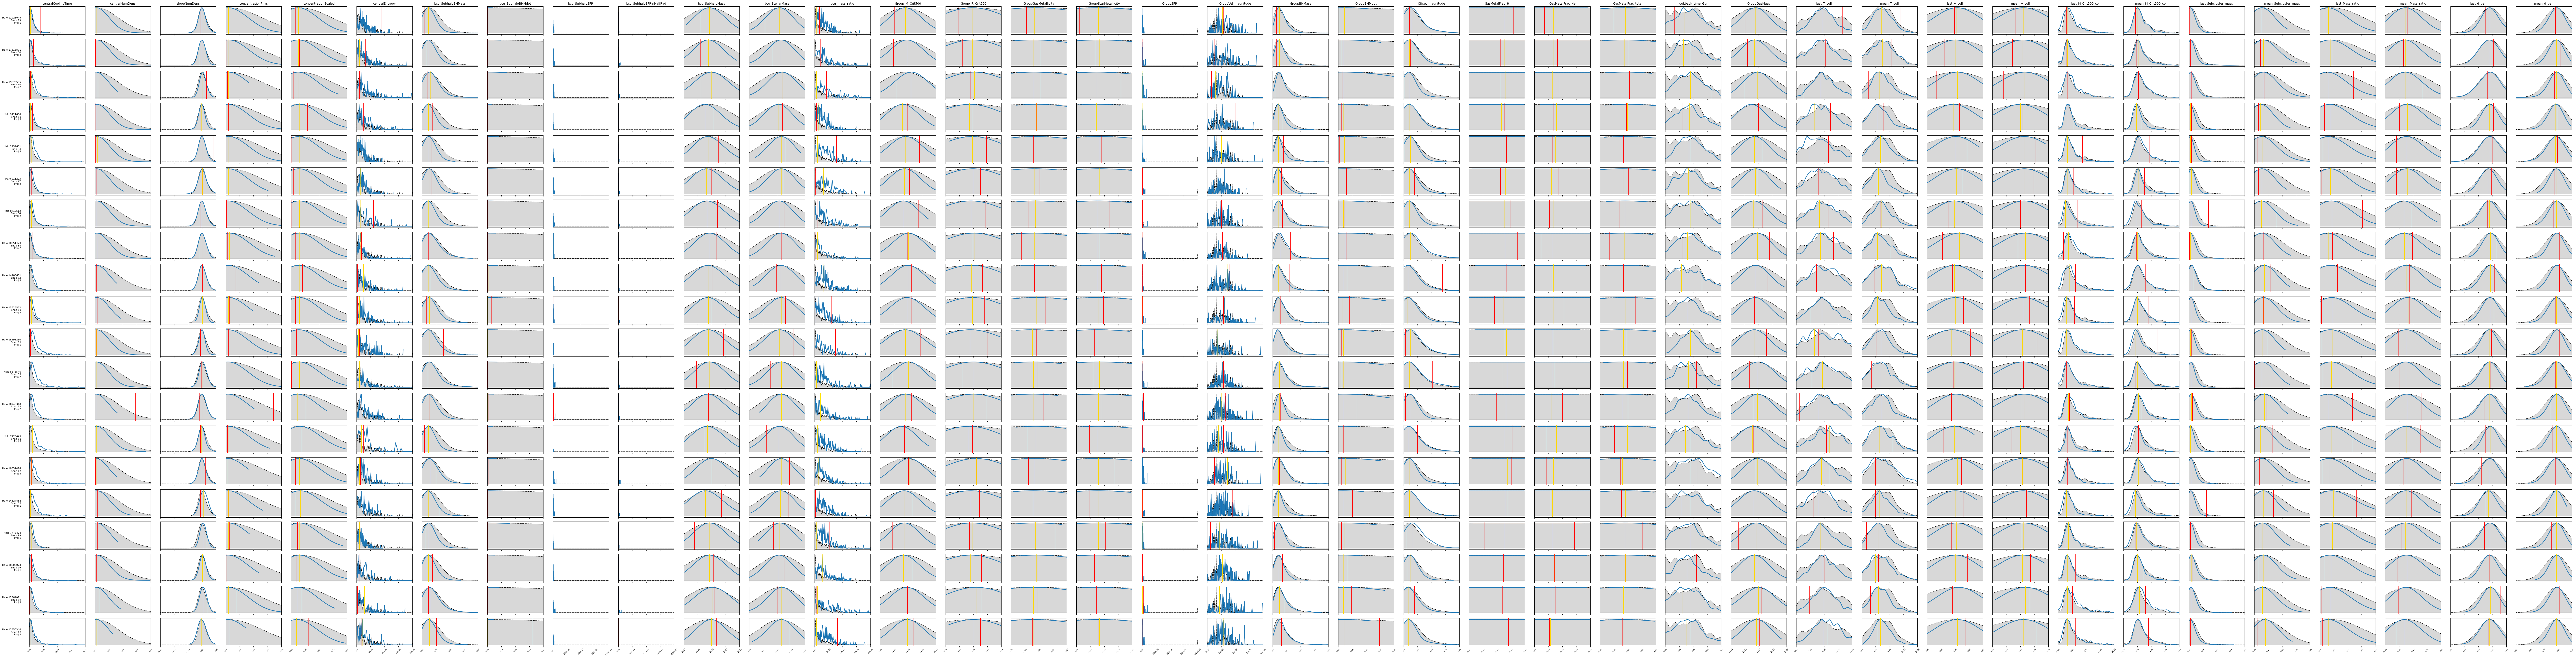

In [27]:
plot_figure14_combined(
    joint_checkpoint="/u/jshera/MAPS_CINN/checkpoints/joint_last.ckpt",
    processed_dir="/u/jshera/MAPS_CINN/simclr_results/processed_data",
    filenames_npy="/u/jshera/MAPS_CINN/simclr_results/filenames.npy",
    n_rows=20,
    n_samples=600,
    random_state=42,
    select_rows = None
)